# 🕸 Síťová analýza PID

## 📚 Data
Jako dataset nám poslouží [otevřená data Pražské integrované dopravy](https://pid.cz/o-systemu/opendata/). Konkrétně budeme pracovat s daty [cestovních řádů](https://pid.cz/o-systemu/opendata/#h-gtfs), která jsou původně ve formátu GTFS (General Transit Feed Specification). To je formát, který využívá široká škála softwarových aplikací a kvůli tomu jej při publikaci dat využívají také veřejné dopravní agentury včetně PID. Dataset $D$ jsme sestavili z dat, která pocházejí z [cestovních řádů](https://pid.cz/o-systemu/opendata/#h-gtfs). Více informací o všech souborech a jejich atributech lze nalézt v [dokumentaci formátu GTFS](https://developers.google.com/transit/gtfs/reference).

## Obsah projektu

**✨ Dataset**
* Načtěme si data ze souboru `d.csv`, což je již zmíněný dataset $D$, který obsahuje záznam pro každé dvě **po sobě jdoucí** zastávky nějakého spoje.
* Struktura je následující (pro zjednodušení neuvažujeme service start_date a end_date):
| stop_from | stop_from_name | stop_to | stop_to_name | depart_from | arrive_to | route_type | is_night | mon | tue | wed | thu | fri | sat | sun |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| U699Z3P | Stadion Strahov | U981Z1P | Koleje Strahov | 7:24:00 | 7:25:00 | 3 | 0 | 1 | 1 | 1 | 1 | 1 | 0 | 0 |

* Jedinečným identifikátorem zastávky je **název zastávky**. Pozor na stejné názvy zastávek pro různé dopravní prostředky - u takových zastávek uvažujme, že se jedná o jednu a tutéž stanici.
* V souboru `stops.txt` je u každé zastávky uvedena **zeměpisná šířka a délka**. Tato data můžeme využít pro rozšíření své analýzy a také nám mohou pomoci při layoutování grafu.

**⚙️ Předzpracování dat**

* Atributy `depart_from` a `arrive_to` chceme upravit. Obsahují totiž časové údaje delší než 24 hodin (celkem se jedná o 1.5 % záznamů). Z reference formátu GTFS (info o sloupci, z kterého vznikl `depart_from` a `arive_to`): _Arrival time at a specific stop for a specific trip on a route. … For times occurring after midnight on the service day, enter the time as a value greater than 24:00:00 in HH:MM:SS local time for the day on which the trip schedule begins._


**🕸️ Základní síťová analýza**

Úkolem je analyzovat síť zastávek PID. Zastávky tedy budou uzly sítě. Mezi dvěma zastávkami je orientovaná hrana, pokud jsou to dvě po sobě jdoucí zastávky nějakého spoje (existuje alespoň jeden záznam v datasetu $D$ s odpovídajícími `stop_from`, `stop_to`). Váha hrany je rovna počtu dopravních prostředků, které na dané trase za období jednoho týdne projedou.

* Začněme volbou libovolného balíčku pro analýzu a vizualizaci sítí.
* Z datasetu $D$ vytvořme reprezentaci dat, která je vhodná pro námi zvolený vizualizační balíček.
* Vytvořme vizualizaci sítě - vizualizace musí být čitelná, proto vizualizujeme podčást sítě.
* Pomocí alespoň tří měr centrality analyzujme důležitost zastávek za období jednoho týdne (pondělí - neděle) a komentujme, co tyto míry vzhledem ke konkrétním datům znamenají.
* Vytvořme vizualizaci pro alespoň jednu míru centrality.

**❓ Vlastní otázky**

* Mění se důležité zastávky v závislosti na denním/nočním provozu?
* Je rozdíl ve vytíženosti zastávek během pracovního týdne/víkendu?
* Na kterých tramvajových zastávkách je možné nastoupit s invalidním vozíkem?

In [262]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np

import networkx as nx
from matplotlib.lines import Line2D

# Datasets

Načtěme si data ze souboru `d.csv` a `stops.txt`

In [263]:
df = pd.read_csv('d.csv')
df.head(10)

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0
5,U4609Z301,Dobříň,U4610Z301,Záluží,4:38:00,4:39:00,2,0,1,1,1,1,1,0,0
6,U4610Z301,Záluží,T58005,Hněvice seř.n.,4:39:00,4:40:30,2,0,1,1,1,1,1,0,0
7,T58005,Hněvice seř.n.,U2991Z301,Hněvice,4:40:30,4:41:30,2,0,1,1,1,1,1,0,0
8,U2991Z301,Hněvice,T58005,Hněvice seř.n.,5:53:00,5:54:30,2,0,1,1,1,1,1,1,1
9,T58005,Hněvice seř.n.,U4610Z301,Záluží,5:54:30,5:56:00,2,0,1,1,1,1,1,1,1


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


Budeme vizualizovat tramvajovou síť, podle dokumentace má tramvaj priznak `"route_type"` je roven 0

In [265]:
df['route_type'].value_counts()

3    954268
0    575015
1     56464
2     55672
4       698
7       316
Name: route_type, dtype: int64

In [266]:
stops = pd.read_csv('stops.txt')
stops

,stop_id,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,level_id,platform_code,asw_node_id,asw_stop_id
0,U50S1,Budějovická,50.044411,14.448787,P,NaN,1,NaN,1,NaN,NaN,50.0,NaN
1,U52S1,Chodov,50.031672,14.490961,P,NaN,1,NaN,1,NaN,NaN,52.0,NaN
2,U75S1,Kolbenova,50.110395,14.516398,P,NaN,1,NaN,1,NaN,NaN,75.0,NaN
3,U78S1,Ládví,50.126591,14.469451,P,NaN,1,NaN,1,NaN,NaN,78.0,NaN
4,U100S1,Vltavská,50.100298,14.438492,P,NaN,1,NaN,1,NaN,NaN,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16430,U897S1E18,E1,50.108672,14.576734,NaN,NaN,2,U897S1,1,U897L1,NaN,897.0,NaN
16431,U897N4,NaN,50.108754,14.576522,NaN,NaN,3,U897S1,1,U897L0,NaN,NaN,NaN
16432,U897N5,NaN,50.108652,14.576557,NaN,NaN,3,U897S1,1,U897L0,NaN,NaN,NaN
16433,U897N7,NaN,50.109134,14.577566,NaN,NaN,3,U897S1,1,U897L1N,NaN,NaN,NaN


In [267]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              16435 non-null  object 
 1   stop_name            15936 non-null  object 
 2   stop_lat             16435 non-null  float64
 3   stop_lon             16435 non-null  float64
 4   zone_id              15408 non-null  object 
 5   stop_url             0 non-null      float64
 6   location_type        16435 non-null  int64  
 7   parent_station       954 non-null    object 
 8   wheelchair_boarding  16435 non-null  int64  
 9   level_id             954 non-null    object 
 10  platform_code        14750 non-null  object 
 11  asw_node_id          15748 non-null  float64
 12  asw_stop_id          15354 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.6+ MB


# Předzpracování dat

## Depart_from, arrive_to to datetime

Pro převod času do 24-hodinového formátu použijeme vestavěnou funkci `"to_timedelta"`

In [268]:
# Convert to time format, including days
df['arrive_to'] = pd.to_timedelta(df['arrive_to'])

# Take only time (remove days by slicing)
df['arrive_to'] = df['arrive_to'].astype(str).str[-8:]

# Same for second attribute
df['depart_from'] = pd.to_timedelta(df['depart_from']).astype(str).str[-8:]

# Základní síťová analýza

## Vytvoření grafu

Nyní připravíme dataset a vytvoříme orientovaný graf. Jak bylo napsáno v předchozí záložce, budeme vizualizovat pouze  <ins>tramvajovou síť.</ins> 

Před vytvořením grafu musíme hranám přiřadit váhy

Je třeba sečíst, kolikrát danou trasu projela vozidla ( s použitím informací o tom, kolikrát danou trasu projela kazde vozidlo za jeden týden )

In [269]:
# Create weights of edges (the number of vehicles travelling on a given route in a one-week period)

# How many times each vehicle crossed the route in one-week period
df['weight'] = df['monday'] + df['tuesday'] + df['wednesday'] + df['thursday'] + df['friday'] + df['saturday'] + df['sunday']

# Sum up
tmp = df[df['route_type'] == 0].groupby(['stop_from_name','stop_to_name']).sum()
edges = tmp['weight'].reset_index(name="weight")
max_weight = edges.max()['weight']

# This attribute will be used to compute centralities
# For more info: closeness_centrality
tmp['distance'] = max_weight / tmp['weight'] 
distances = tmp['distance'].reset_index(name="distance")

edges['distance'] = distances['distance']
edges

,stop_from_name,stop_to_name,weight,distance
0,Albertov,Botanická zahrada,3113,3.504979
1,Albertov,Ostrčilovo náměstí,5093,2.142352
2,Albertov,Výtoň,1700,6.418235
3,Anděl,Arbesovo náměstí,4345,2.511162
4,Anděl,Bertramka,7207,1.513945
...,...,...,...,...
656,Švandovo divadlo,Arbesovo náměstí,4333,2.518117
657,Švandovo divadlo,Újezd,4345,2.511162
658,Želivského,Nákladové nádraží Žižkov,4928,2.214083
659,Želivského,Olšanské hřbitovy,3545,3.077856


In [270]:
# Create Directed Graph
G = nx.from_pandas_edgelist(edges,'stop_from_name','stop_to_name',edge_attr=['weight','distance'],create_using=nx.DiGraph())

In [271]:
# Print first 10 edges with data
k = 0
for i in (G.edges(data=True)):
      print (i)
      k += 1
      if k == 10:
            break

('Albertov', 'Botanická zahrada', {'weight': 3113, 'distance': 3.504979119820109})
('Albertov', 'Ostrčilovo náměstí', {'weight': 5093, 'distance': 2.142352248183782})
('Albertov', 'Výtoň', {'weight': 1700, 'distance': 6.418235294117647})
('Botanická zahrada', 'Albertov', {'weight': 3316, 'distance': 3.290410132689988})
('Botanická zahrada', 'Karlovo náměstí', {'weight': 3113, 'distance': 3.504979119820109})
('Ostrčilovo náměstí', 'Albertov', {'weight': 4813, 'distance': 2.2669852482858923})
('Ostrčilovo náměstí', 'Svatoplukova', {'weight': 5093, 'distance': 2.142352248183782})
('Výtoň', 'Albertov', {'weight': 1777, 'distance': 6.140123804164322})
('Výtoň', 'Palackého náměstí (nábřeží)', {'weight': 5738, 'distance': 1.9015336354130359})
('Výtoň', 'Podolská vodárna', {'weight': 4658, 'distance': 2.342421640188922})


Ověříme, zda byl součet vozidel jedoucích po dané trase za jeden týden vypočítán správně.

Proto mají trasy (hrany) správné váhy

In [272]:
# We will do this only for route "Albertov - Ostrčilovo náměstí"
tmp1 = df[df['route_type'] == 0]
tmp1 = tmp1[tmp1['stop_from_name'] == "Albertov"][tmp1['stop_to_name'] == "Ostrčilovo náměstí"]
tmp1['weight'].sum()

5093

Vypada, že jsme na správné cestě

Ted' vypocteme pozici pro kazdou zastávku. V pripade nekolika zastavek s trochu jinou lokací vypocteme prumer:

In [273]:
pos = {}
for i,x in enumerate(G.nodes()):
      pos_list = []
      stops_list = stops[stops['stop_name'] == x]
      for index in range(len(stops_list)):
            pos_list.append([stops_list.iloc[index,3],stops_list.iloc[index,2]])
      mean_lon, mean_lat = 0, 0
      for lon,lat in pos_list:
            mean_lon += lon
            mean_lat += lat
      pos[x] = np.array([mean_lon/len(pos_list) ,mean_lat/len(pos_list)])
pos

{'Albertov': array([14.420798, 50.067917]),
 'Botanická zahrada': array([14.419263, 50.070776]),
 'Ostrčilovo náměstí': array([14.424233 , 50.0652065]),
 'Výtoň': array([14.4154344, 50.0676706]),
 'Anděl': array([14.4034065, 50.0711323]),
 'Arbesovo náměstí': array([14.404773 , 50.0759782]),
 'Bertramka': array([14.3928615, 50.072235 ]),
 'Křížová': array([14.40514925, 50.06312175]),
 'Na Knížecí': array([14.405169  , 50.06858175]),
 'Zborovská': array([14.40739233, 50.07245267]),
 'Švandovo divadlo': array([14.4046905 , 50.07848633]),
 'Arena Libeň jih': array([14.494592, 50.102892]),
 'Nádraží Libeň': array([14.502603 , 50.1020335]),
 'Ocelářská': array([14.4884195, 50.103544 ]),
 'Balabenka': array([14.4825868, 50.104022 ]),
 'Divadlo Gong': array([14.488343 , 50.1066685]),
 'Palmovka': array([14.47471521, 50.10399593]),
 'Baterie': array([14.369619, 50.092396]),
 'Ořechovka': array([14.3792125, 50.092878 ]),
 'Vojenská nemocnice': array([14.36006233, 50.09171433]),
 'Belárie': arra

## Vizualizace siti

Muzeme vizualizovat sit'. Najdeme konecne zastavky a ulozime jejich jmena:

In [274]:
import copy
labels = {}
for x,i in sorted(G.out_degree,key=lambda x: x[1]):
      if (i != 1):
            break
      labels[x] = x

# Little correction to make graph more legible
pos_labels = copy.deepcopy(pos)
pos_labels['Levského'] += [0.002,0.002]
pos_labels['Lehovec'] -= [0.000, 0.001]
pos_labels['Vozovna Kobylisy'] -= [0.002, 0]
pos_labels['Divadlo pod Palmovkou'] += [0.000, 0.0005]
pos_labels['Nádraží Hostivař'] -= [-0.005, 0.001]
pos_labels['Korunovační'] += [0.000,0.002]
pos_labels['U Průhonu'] -= [0.005,0.000]
pos_labels['Vozovna Pankrác'] += [0.000, 0.001]

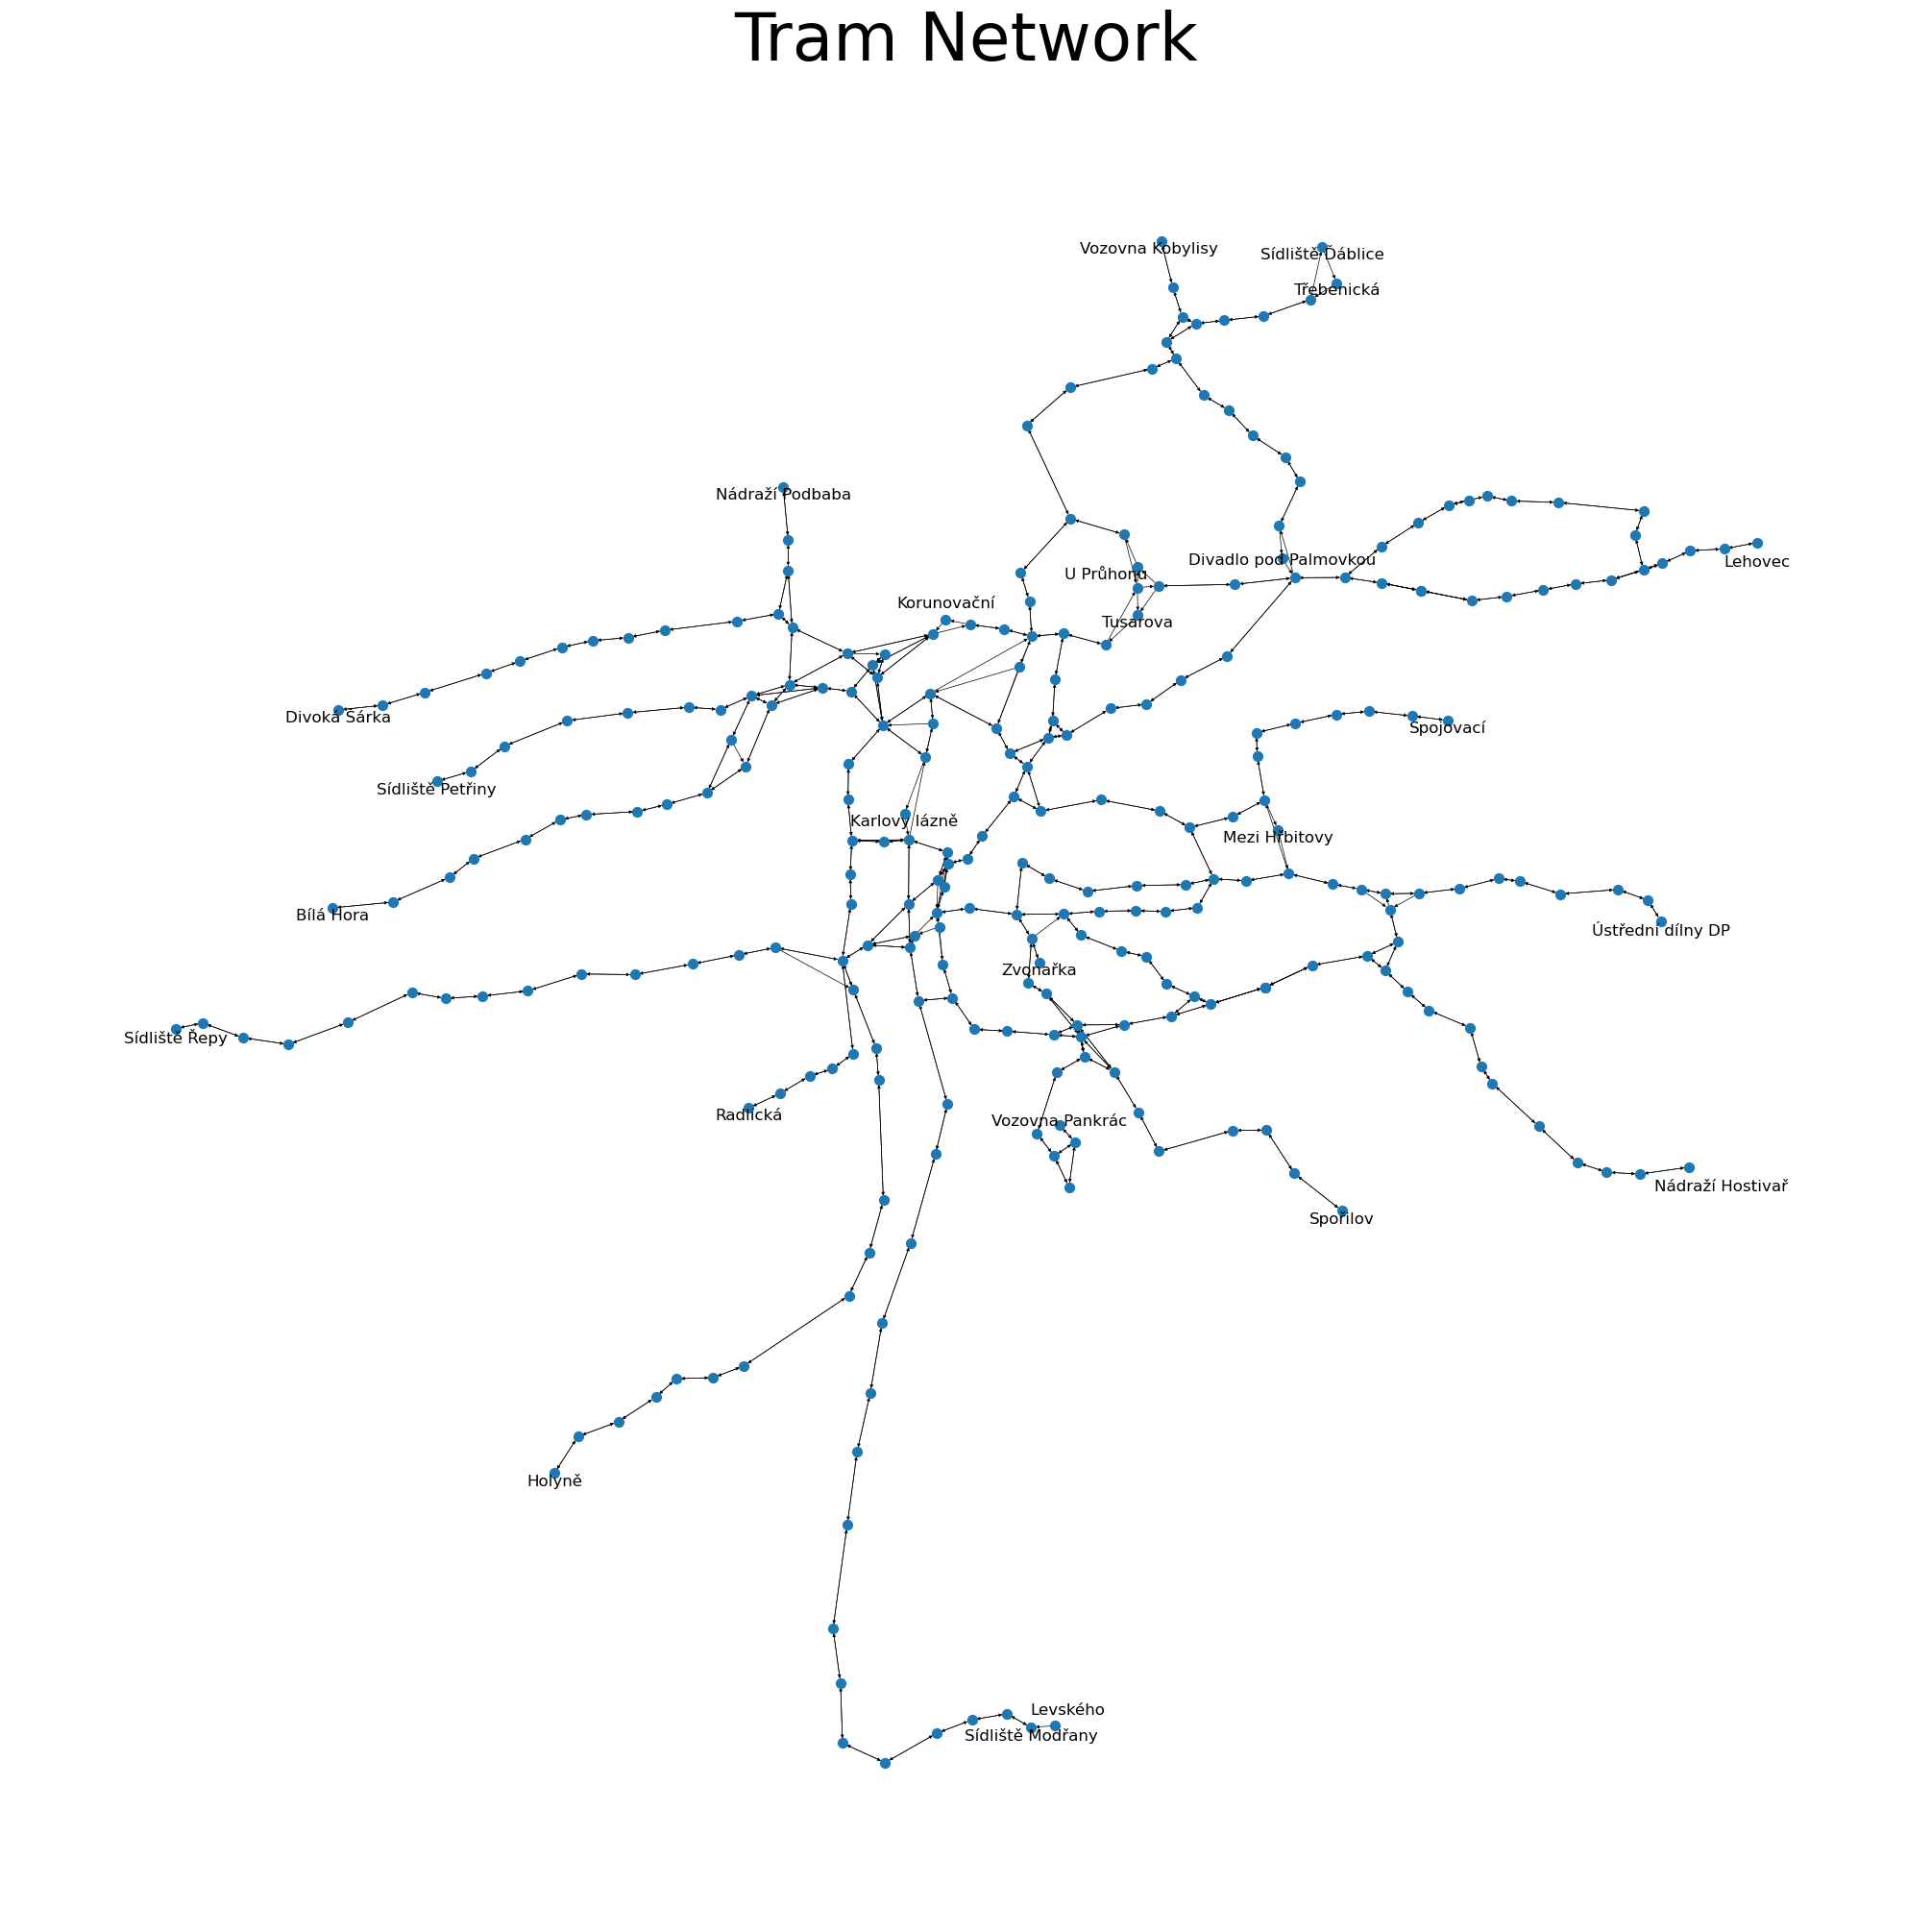

In [275]:
fig, ax = plt.subplots(figsize=(20, 20),constrained_layout= True)

nx.draw_networkx_nodes(G,pos,node_size=50,ax=ax)
nx.draw_networkx_edges(G,pos,node_size=50,ax=ax,arrowsize=5,style='solid',width=0.5)
nx.draw_networkx_labels(G,pos_labels,labels=labels,font_size=12,verticalalignment='top')
plt.suptitle("Tram Network",fontsize=50)
plt.axis('off')
plt.show()

Graf znázorňuje síť tramvajových zastávek ve Praze.  Vrcholy se signaturou jsou konečné zastávky.

## Analyz důležitost zastávek

Nyní analyzujme naši síť pomocí několika centrálit. Zde použijeme:
* centralitu stupně (degree centrality)
* centralitu blízkosti (closeness centrality) (nejprve však musíme ověřit, zda je náš graf propojený)
* centralitu mezilehlosti (betweenness centrality)

### Test souvislosti

In [276]:
nx.is_strongly_connected(G)

False

In [277]:
nx.is_weakly_connected(G)

True

Myslim, ze slaba souvislost je tady proto, ze mame jednu zastavku z in_degree = 0 (cili do ktere nic nedojizdi). Z grafu je videt, ze je to "Levskeho":

In [278]:
G.in_degree("Levského")

0

Muzeme odebrat tuto zastavku, anebo nechame jak to je a pokracujme dal.

### Centralita stupně

Stupňová centralita uzlu ukazuje na významnost vrcholu podle jeho stupně. Pro počitani stupňovych centralit pro kazdy vrchol pouzijme vestavenou funkci `"nx.degree_centrality"`

In [279]:
deg_cent = nx.degree_centrality(G)

# Sort by value in ascending order
degree_centrality = []
for x in deg_cent.keys():
      degree_centrality.append([x,deg_cent[x]]);
degree_centrality.sort(key=lambda x: x[1])

print("{:^51}".format("Degree Centrality"))
print("====================TOP 5 STOPS====================")
for x,i in degree_centrality[:-6:-1]:
      print("{:<30}{}".format(x,i))
print("\n\n")
print("------------------BOTTOM 10 STOPS------------------")
for x,i in degree_centrality[:10:]:
      print("{:<30}{}".format(x,i))

                 Degree Centrality                 
====================TOP 5 STOPS====================
Malostranská                  0.04642857142857143
Otakarova                     0.04285714285714286
Náměstí Bratří Synků          0.04285714285714286
Národní divadlo               0.03571428571428571
Vozovna Střešovice            0.03571428571428571



------------------BOTTOM 10 STOPS------------------
Levského                      0.0035714285714285713
Sídliště Řepy                 0.007142857142857143
Zvonařka                      0.007142857142857143
Bílá Hora                     0.007142857142857143
Divadlo pod Palmovkou         0.007142857142857143
Divoká Šárka                  0.007142857142857143
Holyně                        0.007142857142857143
Nádraží Hostivař              0.007142857142857143
Karlovy lázně                 0.007142857142857143
Spojovací                     0.007142857142857143


Z obsahu pole je patrné, že zastávky s malou hodnotou stupneve centrality jsou obvykle konečné zastávky. Konkrétně nejmenší hodnotu má zastávka Levského, ze které doprava pouze odjíždí, ale nepřijíždí. 

Naopak vysokou hodnotu centrality mají zastávky v centru Prahy (např. Národní divadlo, Malostranská). Jsou spojene s vyssim poctem zastavek a proto jsou dulezite. Níže vytvoříme vizualizaci této centrality.

### Centralita blízkosti

Centralita blízkosti ukazuje na důležite aktéry vzhledem k jeho průměrné vzdálenosti od všech dosažitelných vrcholů v síti:
Čím blíže je aktér k ostatním aktérům, tím je důležitější.

Proto tato centralita pocita vdalenost mezi vrcholy. Jelikoz mame vahu u hran, která nepředstavuje vzdálenost mezi zastávkami, ale počet vozů, které mezi těmito zastávkami za týden projedou, nemusí výpočty odrážet důležité zastávky. 

Je třeba převést váhy na vzdálenosti tak, aby důležité zastávky (tj. ty, jejichž hrany mají vyšší váhu.) byly blíže k sobě (tj. vzdálenost mezi zastávkami je menší, takže se stávají důležitějšími).
Udelame to tak: Kazde vahy $w$ nahradime hodnotou $$\frac{max\_weight}{w}$$ kde $max\_weight$ je maximalni vaha. Tohle jsme udelali v kapitole "Předzpracování dat" (podkapitola "Vytvoření grafu")

In [280]:
close_cent = nx.closeness_centrality(G,distance="distance")

# Sort by value in ascending order
closeness_centrality = []
for x in close_cent.keys():
      closeness_centrality.append([x,close_cent[x]]);
closeness_centrality.sort(key=lambda x: x[1])

print("{:^51}".format("Closeness Centrality"))
print("====================TOP 5 STOPS====================")
for x,i in closeness_centrality[:-6:-1]:
      print("{:<30}{}".format(x,i))
print("\n\n")
print("------------------BOTTOM 10 STOPS------------------")
for x,i in closeness_centrality[:10:]:
      print("{:<30}{}".format(x,i))

               Closeness Centrality                
====================TOP 5 STOPS====================
Karlovo náměstí               0.03168978984434182
Lazarská                      0.030942537282244505
Štěpánská                     0.030919135202691912
Národní třída                 0.03071382880713779
Novoměstská radnice           0.03067023179001387



------------------BOTTOM 10 STOPS------------------
Levského                      0.0
Zvonařka                      0.001227684079745728
Třebenická                    0.010033015316666031
Kolbenova                     0.01032333064955095
Sídliště Ďáblice              0.010639308124852986
Nový Hloubětín                0.011119978471456559
Spořilov                      0.011292467280072481
Štěpničná                     0.011353391777466781
Poštovská                     0.01161729135252077
Sídliště Modřany              0.011815111429162192


Zde se nejdůležitější aktéři liší od těch předchozích. Některé zastávky se nenacházejí v centru (například Lazarská, Štěpánská), ale cesta k nim zabere ve srovnání s ostatními minimum času. 

Nezapomeňme, že vzdálenost byla přepočítána z vah. Pro hrany to znamená následující: nejčastěji jsou využívány zastávky z první pětky(Karlovo náměstí, Lazarská atd.), zatímco zastávky z druhého seznamu jsou využívány méně často. 
* Zajímavé je, že ne každá zastávka je konečnou stanicí v druhém seznamu(napriklad Nový Hloubětín).

Hodnota stanice "Levského" je 0, protože graf je slabě souvisly. Abychom zjistili centralitu této stanice, museli bychom přidat cestu, která končí v této stanici (protože její in_degree = 0).

### Centralita mezilehlosti

Centralita mezilehlosti představuje frekvenci, s jakou se vrchol objevuje na nejkratší cestě mezi jinými dvěma vrcholy.
Nejdulezitejsi aktery jsou ti, přes které proudí nejvíce informací.

I zde použijeme algoritmus pro nalezení nejkratší cesty - tedy použijeme údaje o vzdálenosti z předchozí centrálity:

In [281]:
bet_cent = nx.betweenness_centrality(G,weight='distance')

# Sort by value in ascending order
betweenness_centrality = []
for x in bet_cent.keys():
      betweenness_centrality.append([x,bet_cent[x]]);
betweenness_centrality.sort(key=lambda x: x[1])

print("{:^51}".format("Betweenness Centrality"))
print("====================TOP 5 STOPS====================")
for x,i in betweenness_centrality[:-6:-1]:
      print("{:<30}{}".format(x,i))
print("\n\n")
print("------------------BOTTOM 10 STOPS------------------")
for x,i in betweenness_centrality[:10:]:
      print("{:<30}{}".format(x,i))

              Betweenness Centrality               
====================TOP 5 STOPS====================
Karlovo náměstí               0.3688300051203277
Strossmayerovo náměstí        0.35632360471070146
Vltavská                      0.2752176139272913
Pražská tržnice               0.2662826420890937
Královský letohrádek          0.26561699948796724



------------------BOTTOM 10 STOPS------------------
Sídliště Řepy                 0.0
Zvonařka                      0.0
Bílá Hora                     0.0
Chotkovy sady                 0.0
Špejchar                      0.0
Divoká Šárka                  0.0
Holyně                        0.0
Nádraží Hostivař              0.0
Myslíkova                     0.0
Spojovací                     0.0


Zde vidíme, že zastávky jsou opět jiné. Nyní jsou zastávky z první pětky častěji než ostatní objevuji na nejkratší cestě mezi dalšími dvěma zastávkami - to znamená, že vozidla těmito zastávkami častěji projíždějí. 

Zastávky s nejnižšími hodnotami jsou ty, do kterých vedou hrany s nejnižší vahou. Jedná se nejčastěji o konečné zastávky, ale nejen o ně (např. Myslíkova).

## Vizualizace centrality stupně

Vytvorime funkce, protoze budeme potrebovat vic vizualizaci:

In [282]:
def draw(G, pos, centrality, centrality_name):
      fig, ax = plt.subplots(figsize=(20, 18))

      # Use  plasma colormap from plot
      nodes = nx.draw_networkx_nodes(G,pos,node_size=50,ax=ax,cmap=plt.plasma(),node_color=list(centrality.values()))
      nx.draw_networkx_edges(G,pos,node_size=50,ax=ax,arrowsize=5,style='solid',width=0.5)
      # nx.draw_networkx_labels(G,pos_labels,labels=labels,font_size=12,verticalalignment='top')

      plt.title(centrality_name,fontdict={'fontsize':50})
      
      # Add colorbar
      plt.colorbar(nodes)
      plt.axis('off')
      plt.show()

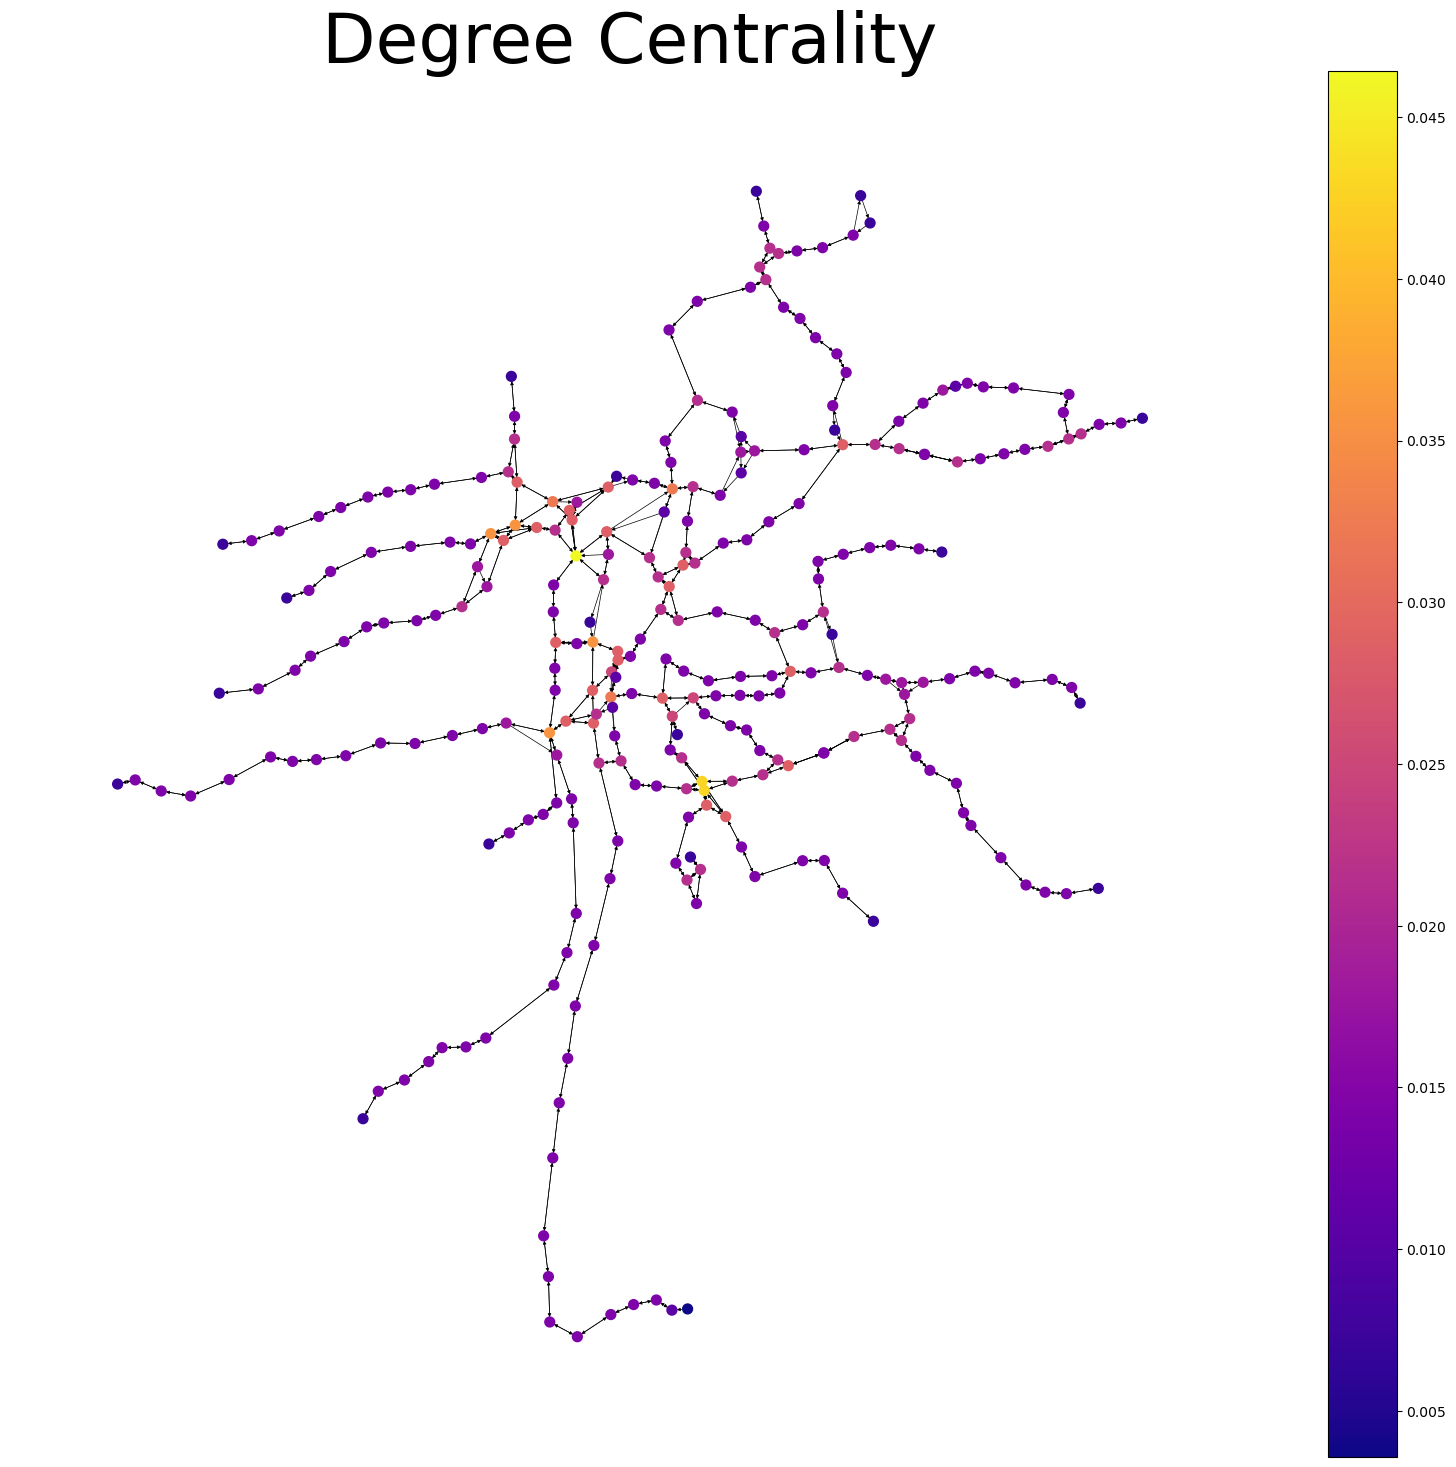

In [283]:
draw(G, pos, nx.degree_centrality(G),"Degree Centrality")

# Vlastní otázky

## Mění se důležité zastávky tramvaje v závislosti na denním/nočním provozu?

Tuto otázku lze zodpovědět tak, že dataset rozfiltrujeme na noční a denní trasy, vypočítáme centralitu pro každý typ trasy zvlášť a na konci porovnáme výsledky.

In [284]:
# Day edges
trams = df[df['route_type'] == 0]
day_routes = trams[trams['is_night'] == 0].groupby(['stop_from_name','stop_to_name']).sum()
day_edges = day_routes['weight'].reset_index(name="weight")
max_weight = day_edges.max()['weight']

day_routes['distance'] = max_weight / day_routes['weight'] 
day_distances = day_routes['distance'].reset_index(name="distance")

day_edges['distance'] = day_distances['distance']
display(day_edges)

# Night edges
night_routes = trams[trams['is_night'] == 1].groupby(['stop_from_name','stop_to_name']).sum()
night_edges = night_routes['weight'].reset_index(name="weight")
max_weight = night_edges.max()['weight']

night_routes['distance'] = max_weight / night_routes['weight'] 
night_distances = night_routes['distance'].reset_index(name="distance")

night_edges['distance'] = night_distances['distance']
display(night_edges)

day_G = nx.from_pandas_edgelist(day_edges,'stop_from_name','stop_to_name',edge_attr=['weight','distance'],create_using=nx.DiGraph())
night_G = nx.from_pandas_edgelist(night_edges,'stop_from_name','stop_to_name',edge_attr=['weight','distance'],create_using=nx.DiGraph())

,stop_from_name,stop_to_name,weight,distance
0,Albertov,Botanická zahrada,2900,3.552759
1,Albertov,Ostrčilovo náměstí,4858,2.120832
2,Albertov,Výtoň,1700,6.060588
3,Anděl,Arbesovo náměstí,4115,2.503767
4,Anděl,Bertramka,6877,1.498182
...,...,...,...,...
652,Švandovo divadlo,Arbesovo náměstí,4136,2.491054
653,Švandovo divadlo,Újezd,4115,2.503767
654,Želivského,Nákladové nádraží Žižkov,4768,2.160864
655,Želivského,Olšanské hřbitovy,3305,3.117398


,stop_from_name,stop_to_name,weight,distance
0,Albertov,Botanická zahrada,213,4.713615
1,Albertov,Ostrčilovo náměstí,235,4.272340
2,Anděl,Arbesovo náměstí,230,4.365217
3,Anděl,Bertramka,330,3.042424
4,Anděl,Na Knížecí,70,14.342857
...,...,...,...,...
545,Švandovo divadlo,Arbesovo náměstí,197,5.096447
546,Švandovo divadlo,Újezd,230,4.365217
547,Želivského,Nákladové nádraží Žižkov,160,6.275000
548,Želivského,Olšanské hřbitovy,240,4.183333


In [285]:
# Day
day_deg_cent = nx.degree_centrality(day_G)
day_close_cent = nx.closeness_centrality(day_G,distance="distance")
day_bet_cent = nx.betweenness_centrality(day_G,weight='distance')

# Sort by value in ascending order
day_degree_centrality = []
day_closeness_centrality = []
day_betweenness_centrality = []

for x in day_deg_cent.keys():
      day_degree_centrality.append([x,day_deg_cent[x]]);
day_degree_centrality.sort(key=lambda x: x[1])

for x in day_close_cent.keys():
      day_closeness_centrality.append([x,day_close_cent[x]]);
day_closeness_centrality.sort(key=lambda x: x[1])

for x in day_bet_cent.keys():
      day_betweenness_centrality.append([x,day_bet_cent[x]]);
day_betweenness_centrality.sort(key=lambda x: x[1])



# Night
night_deg_cent = nx.degree_centrality(night_G)
night_close_cent = nx.closeness_centrality(night_G,distance="distance")
night_bet_cent = nx.betweenness_centrality(night_G,weight='distance')

# Sort by value in ascending order
night_degree_centrality = []
night_closeness_centrality = []
night_betweenness_centrality = []


for x in night_deg_cent.keys():
      night_degree_centrality.append([x,night_deg_cent[x]]);
night_degree_centrality.sort(key=lambda x: x[1])

for x in night_close_cent.keys():
      night_closeness_centrality.append([x,night_close_cent[x]]);
night_closeness_centrality.sort(key=lambda x: x[1])

for x in night_bet_cent.keys():
      night_betweenness_centrality.append([x,night_bet_cent[x]]);
night_betweenness_centrality.sort(key=lambda x: x[1])

# My take on pretty printing
print("{:^51}    {:^51}".format("Day Routes","Night Routes"))
print("{:^106}".format("Degree Centrality"))
print("{:^51}     {:^51}".format("====================TOP 10 STOPS===================","====================TOP 10 STOPS===================="))
for day_x,night_x in zip(day_degree_centrality[:-11:-1],night_degree_centrality[:-11:-1]):
      print("{:<30}{:<21}     {:<30}{:<21}".format(day_x[0],day_x[1],night_x[0],night_x[1]))
print("\n\n")
print("{:^51}     {:^51}".format("------------------BOTTOM 10 STOPS------------------","------------------BOTTOM 10 STOPS------------------"))
for day_x,night_x in zip(day_degree_centrality[:10:],night_degree_centrality[:10:]):
      print("{:<30}{:<21}     {:<30}{:<21}".format(day_x[0],day_x[1],night_x[0],night_x[1]))

                    Day Routes                                            Night Routes                    
                                            Degree Centrality                                             
====================TOP 10 STOPS===================     ====================TOP 10 STOPS====================
Malostranská                  0.04642857142857143       Otakarova                     0.04263565891472868  
Náměstí Bratří Synků          0.04285714285714286       Národní divadlo               0.031007751937984496 
Národní divadlo               0.03571428571428571       Prašný most                   0.031007751937984496 
Vozovna Střešovice            0.03571428571428571       Vozovna Střešovice            0.031007751937984496 
Prašný most                   0.03571428571428571       Čechův most                   0.031007751937984496 
Anděl                         0.03571428571428571       Malostranská                  0.031007751937984496 
Strossmayerovo náměstí       

Z toho můžeme vidět, že některé z nejdůležitějších zastávek se ve dvou seznamech liší, zatímco zastavky z posledni desitky jsou téměř stejné.

Pojdme zvizualizovat 10 nejdůležitějších denních a nočních zastávek.
* Oranžová barva označuje zastávky, které jsou v top 10 denních i nočních zastávek
* Žlutá barva - zastávky, které jsou pouze v top 10 denních zastávek
* Fialová barva zastávky, které jsou pouze v top 10 nočních zastávek.

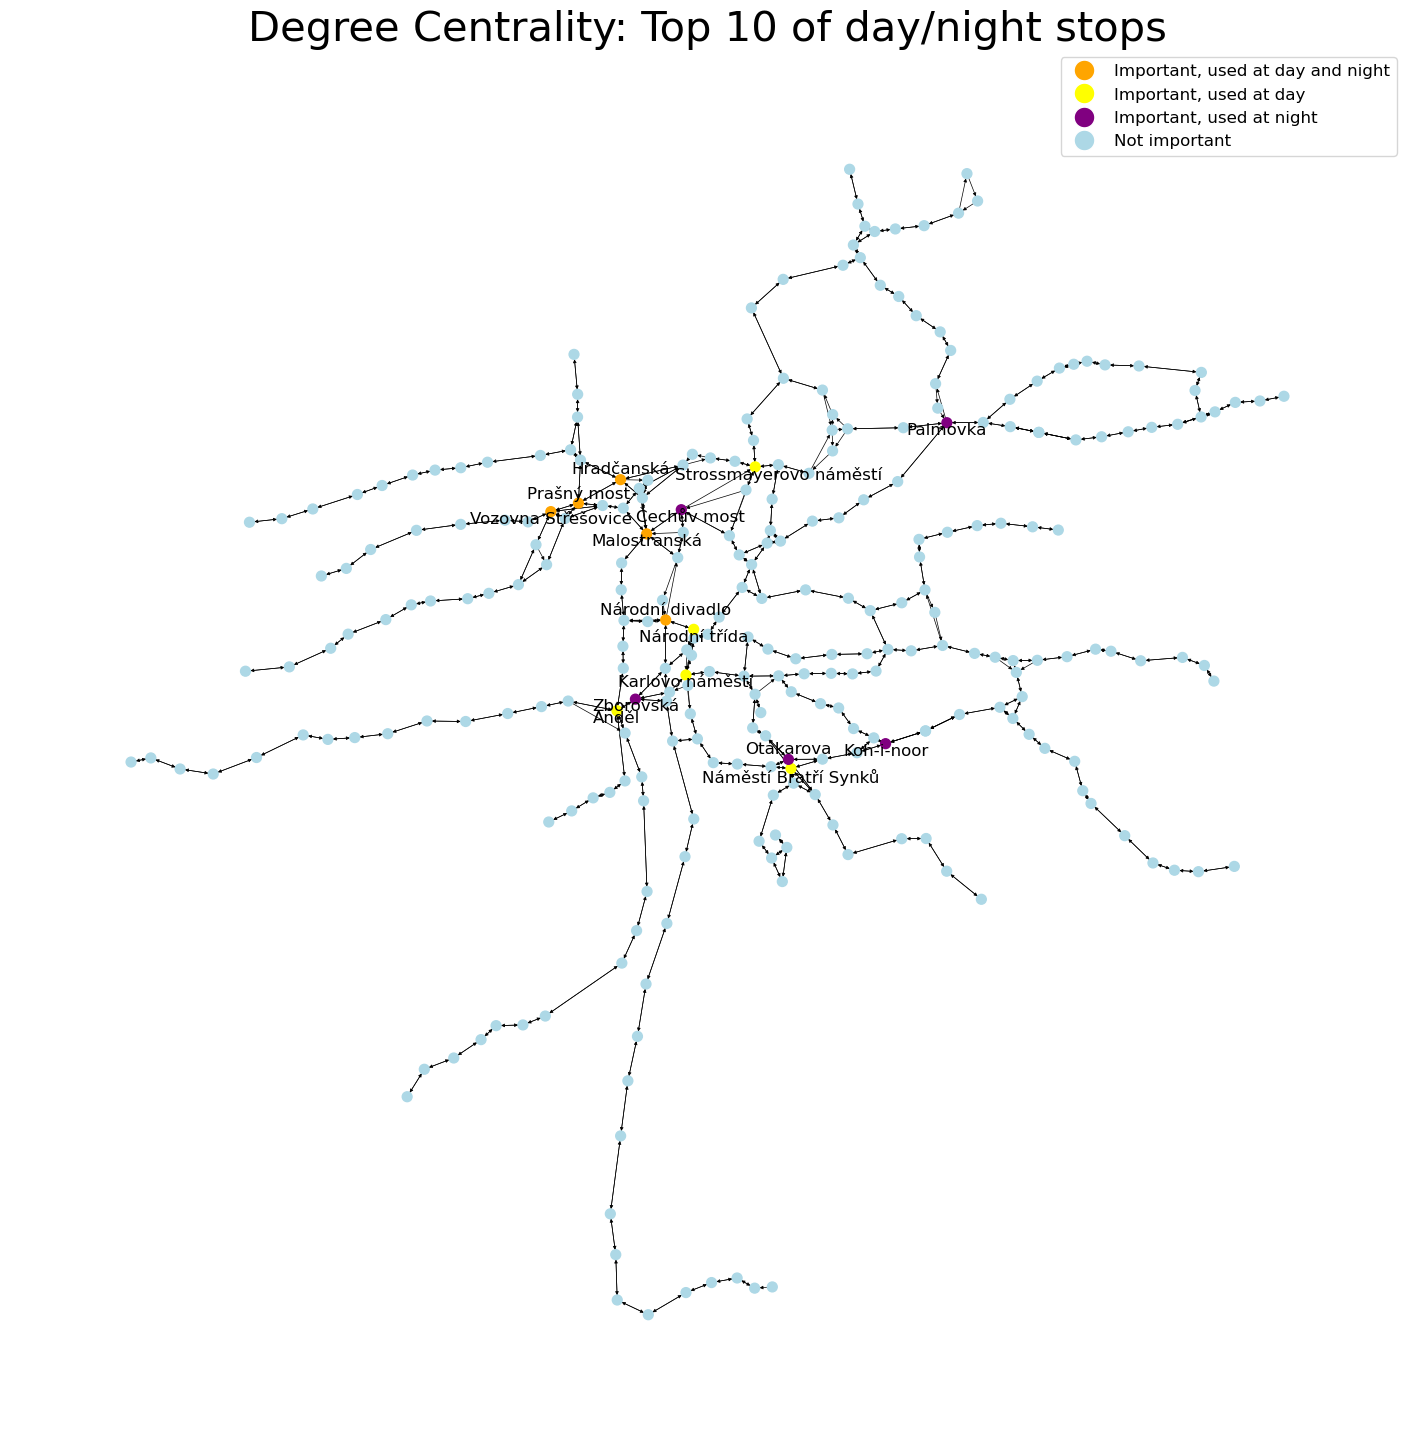

In [286]:
fig, ax = plt.subplots(figsize=(18, 18))

day_nodes = [x[0] for x in day_degree_centrality[:-11:-1]]
night_nodes = [x[0] for x in night_degree_centrality[:-11:-1]]

colormap = []
for node in G.nodes():
      if node in day_nodes and node in night_nodes:
            colormap.append("orange")
      elif node in day_nodes:
            colormap.append("yellow")
      elif node in night_nodes:
            colormap.append("purple")
      else:
            colormap.append("lightblue")

labels = {}
for x in day_nodes:
      labels[x] = x
for x in night_nodes:
      labels[x] = x

# Small correction for legible graph      
pos_labels['Prašný most'] += [0.000,0.002]
pos_labels['Hradčanská'] += [0.000,0.002]
pos_labels['Otakarova'] += [0.000,0.002]
pos_labels['Strossmayerovo náměstí'] += [0.005,0.000]
pos_labels['Čechův most'] += [0.002,0.000]
pos_labels['Národní divadlo'] += [0.000,0.002]

nx.draw_networkx_nodes(G,pos,node_size=50,ax=ax,node_color=colormap)
nx.draw_networkx_edges(G,pos,node_size=50,ax=ax,arrowsize=5,style='solid',width=0.5)
nx.draw_networkx_labels(G,pos_labels,labels=labels,font_size=12,verticalalignment='top')

plt.title("Degree Centrality: Top 10 of day/night stops",fontsize=30)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Important, used at day and night',markerfacecolor='orange', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used at day',markerfacecolor='yellow', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used at night',markerfacecolor='purple', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Not important',markerfacecolor='lightblue', markersize=15),        
]
plt.legend(handles=legend_elements, loc='upper right',fontsize='large')

plt.axis('off')
plt.show()

In [287]:
print("{:^51}    {:^51}".format("Day Routes","Night Routes"))
print("{:^106}".format("Closeness Centrality"))
print("{:^51}    {:^51}".format("====================TOP 10 STOPS===================","====================TOP 10 STOPS===================="))
for day_x,night_x in zip(day_closeness_centrality[:-11:-1],night_closeness_centrality[:-11:-1]):
      print("{:<30}{:<21}    {:<30}{:<21}".format(day_x[0],day_x[1],night_x[0],night_x[1]))
print("\n\n")
print("{:^51}    {:^51}".format("------------------BOTTOM 10 STOPS------------------","------------------BOTTOM 10 STOPS------------------"))
for day_x,night_x in zip(day_closeness_centrality[:10:],night_closeness_centrality[:10:]):
      print("{:<30}{:<21}    {:<30}{:<21}".format(day_x[0],day_x[1],night_x[0],night_x[1]))

                    Day Routes                                            Night Routes                    
                                           Closeness Centrality                                           
====================TOP 10 STOPS===================    ====================TOP 10 STOPS====================
Karlovo náměstí               0.03194579086777349      Lazarská                      0.015705816117695965 
Štěpánská                     0.031157875840742404     Karlovo náměstí               0.015699155507667498 
Újezd                         0.031144379209948142     Vodičkova                     0.015676726936051776 
Národní divadlo               0.031121167599712687     Václavské náměstí             0.015646254787744788 
Lazarská                      0.031050731000516595     Jindřišská                    0.015614752004549533 
Národní třída                 0.03101186282603843      Národní třída                 0.015460564792937557 
Novoměstská radnice           0.0308

Pojdme zvizualizovat i tuto centralitu. Obarveni je stejne: 

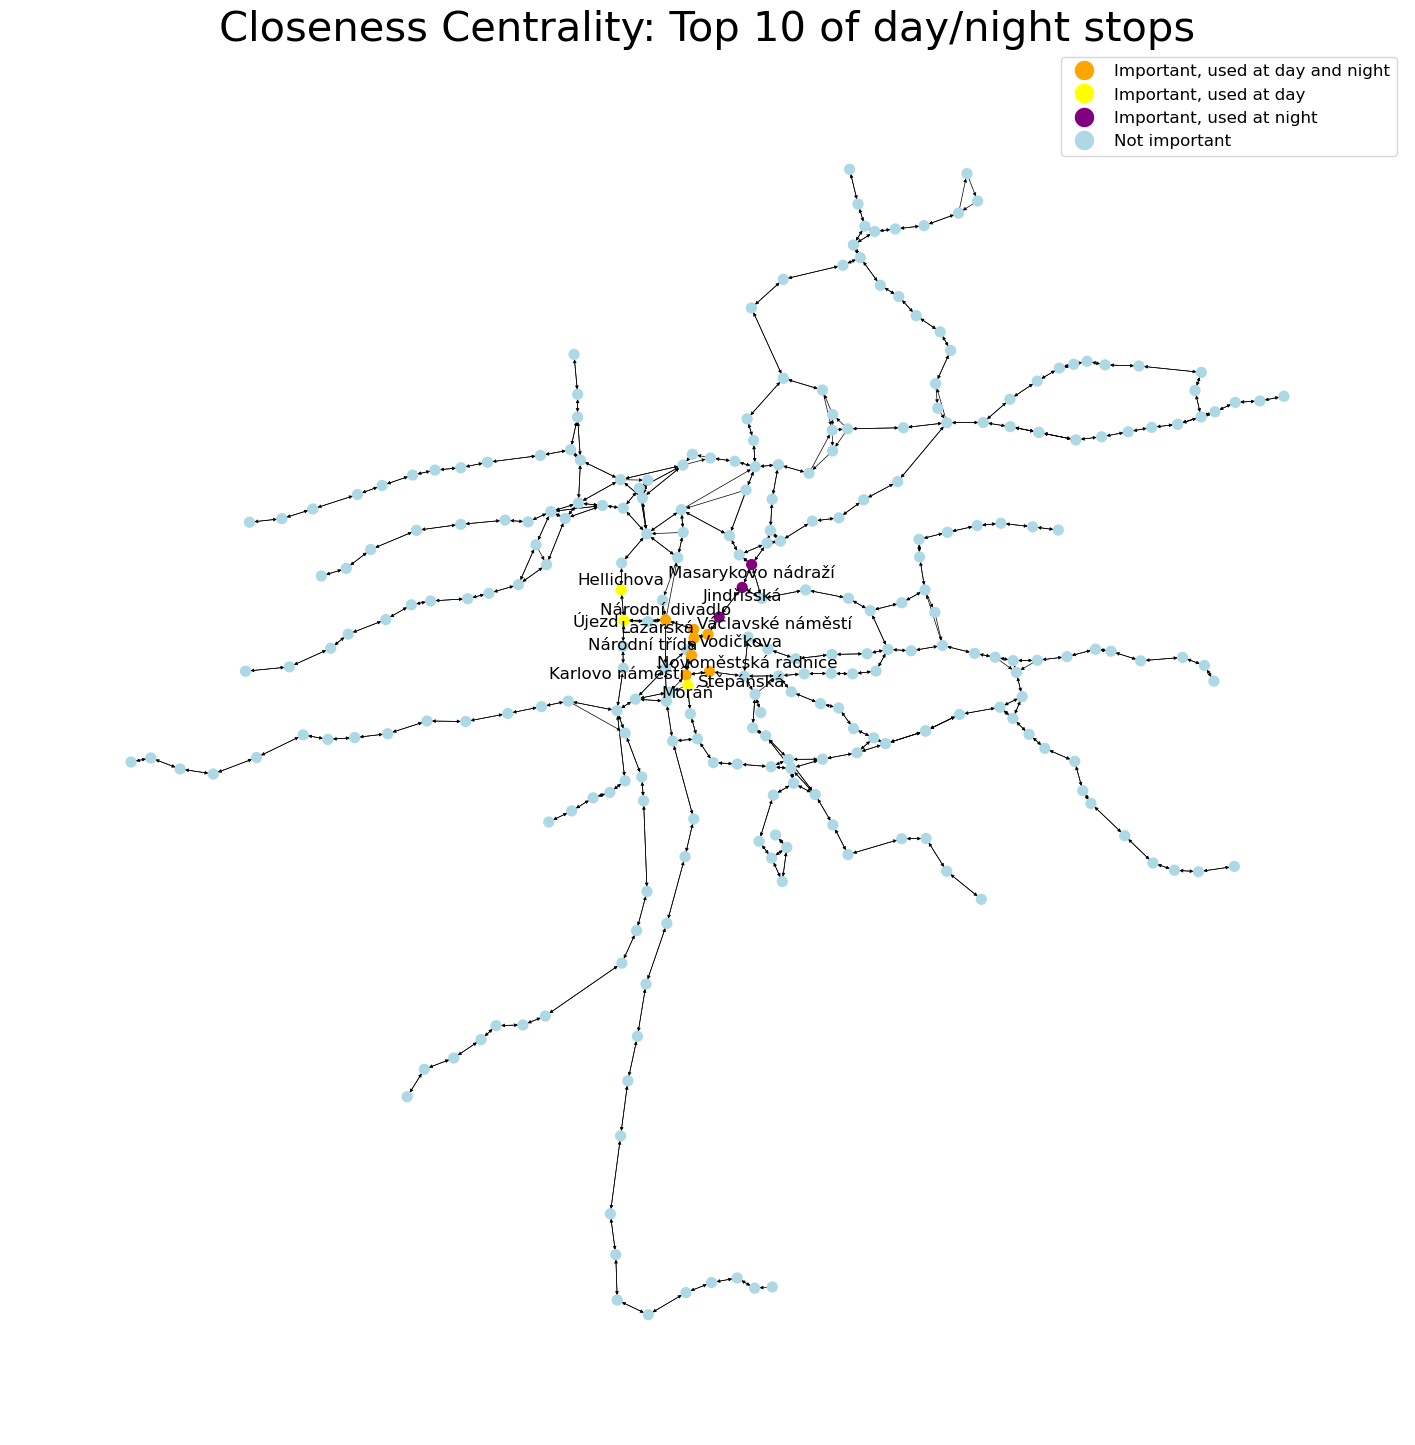

In [288]:
fig, ax = plt.subplots(figsize=(18, 18))

day_nodes = [x[0] for x in day_closeness_centrality[:-11:-1]]
night_nodes = [x[0] for x in night_closeness_centrality[:-11:-1]]

colormap = []
for node in G.nodes():
      if node in day_nodes and node in night_nodes:
            colormap.append("orange")
      elif node in day_nodes:
            colormap.append("yellow")
      elif node in night_nodes:
            colormap.append("purple")
      else:
            colormap.append("lightblue")

labels = {}
for x in day_nodes:
      labels[x] = x
for x in night_nodes:
      labels[x] = x

# Small correction for legible graph
pos_labels['Hellichova'] += [0,0.002]
pos_labels['Újezd'] -= [0.006,-0.001]
pos_labels['Václavské náměstí'] += [0.012,0]
pos_labels['Národní třída'] -= [0.011,0.001]
pos_labels['Novoměstská radnice'] += [0.012,0]
pos_labels['Lazarská'] -= [0.008,-0.002]
pos_labels['Vodičkova'] += [0.007,0]
pos_labels['Štěpánská'] += [0.007,0]
pos_labels['Karlovo náměstí'] -= [0.015,-0.001]

nx.draw_networkx_nodes(G,pos,node_size=50,ax=ax,node_color=colormap)
nx.draw_networkx_edges(G,pos,node_size=50,ax=ax,arrowsize=5,style='solid',width=0.5)
nx.draw_networkx_labels(G,pos_labels,labels=labels,font_size=12,verticalalignment='top')

plt.title("Closeness Centrality: Top 10 of day/night stops",fontsize=30)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Important, used at day and night',markerfacecolor='orange', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used at day',markerfacecolor='yellow', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used at night',markerfacecolor='purple', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Not important',markerfacecolor='lightblue', markersize=15),        
]
plt.legend(handles=legend_elements, loc='upper right',fontsize='large')

plt.axis('off')
plt.show()

Zde je na rozdíl od předchozí centrality mnoho nejdůležitějších zastávek stejných - liší se pouze 3 zastávky.

Je pozoruhodné, že podle této centrality jsou nejdůležitější noční zastávky blíže centru Prahy (pravděpodobně turistická místa). 

Ted' prozkoumame dulezite zastavky pomoci centrality mezilehlosti:

In [289]:
print("{:^51}    {:^51}".format("Day Routes","Night Routes"))
print("{:^106}".format("Betweenness Centrality"))
print("{:^51}    {:^51}".format("====================TOP 5 STOPS====================","====================TOP 5 STOPS===================="))
for day_x,night_x in zip(day_betweenness_centrality[:-6:-1],night_betweenness_centrality[:-6:-1]):
      print("{:<30}{:<21}    {:<30}{:<21}".format(day_x[0],day_x[1],night_x[0],night_x[1]))
print("\n\n")
print("{:^51}    {:^51}".format("------------------BOTTOM 10 STOPS------------------","------------------BOTTOM 10 STOPS------------------"))
for day_x,night_x in zip(day_betweenness_centrality[:10:],night_betweenness_centrality[:10:]):
      print("{:<30}{:<21}    {:<30}{:<21}".format(day_x[0],day_x[1],night_x[0],night_x[1]))

                    Day Routes                                            Night Routes                    
                                          Betweenness Centrality                                          
====================TOP 5 STOPS====================    ====================TOP 5 STOPS====================
Strossmayerovo náměstí        0.35673323092677933      Lazarská                      0.5439326757759478   
Karlovo náměstí               0.354531490015361        Karlovo náměstí               0.45344312731879466  
Vltavská                      0.2758704557091654       Jindřišská                    0.4401110005127741   
Královský letohrádek          0.26761392729134664      Masarykovo nádraží            0.4030856936023889   
Pražská tržnice               0.2669354838709677       Vodičkova                     0.38290652429644373  



------------------BOTTOM 10 STOPS------------------    ------------------BOTTOM 10 STOPS------------------
Sídliště Řepy                 0.0 

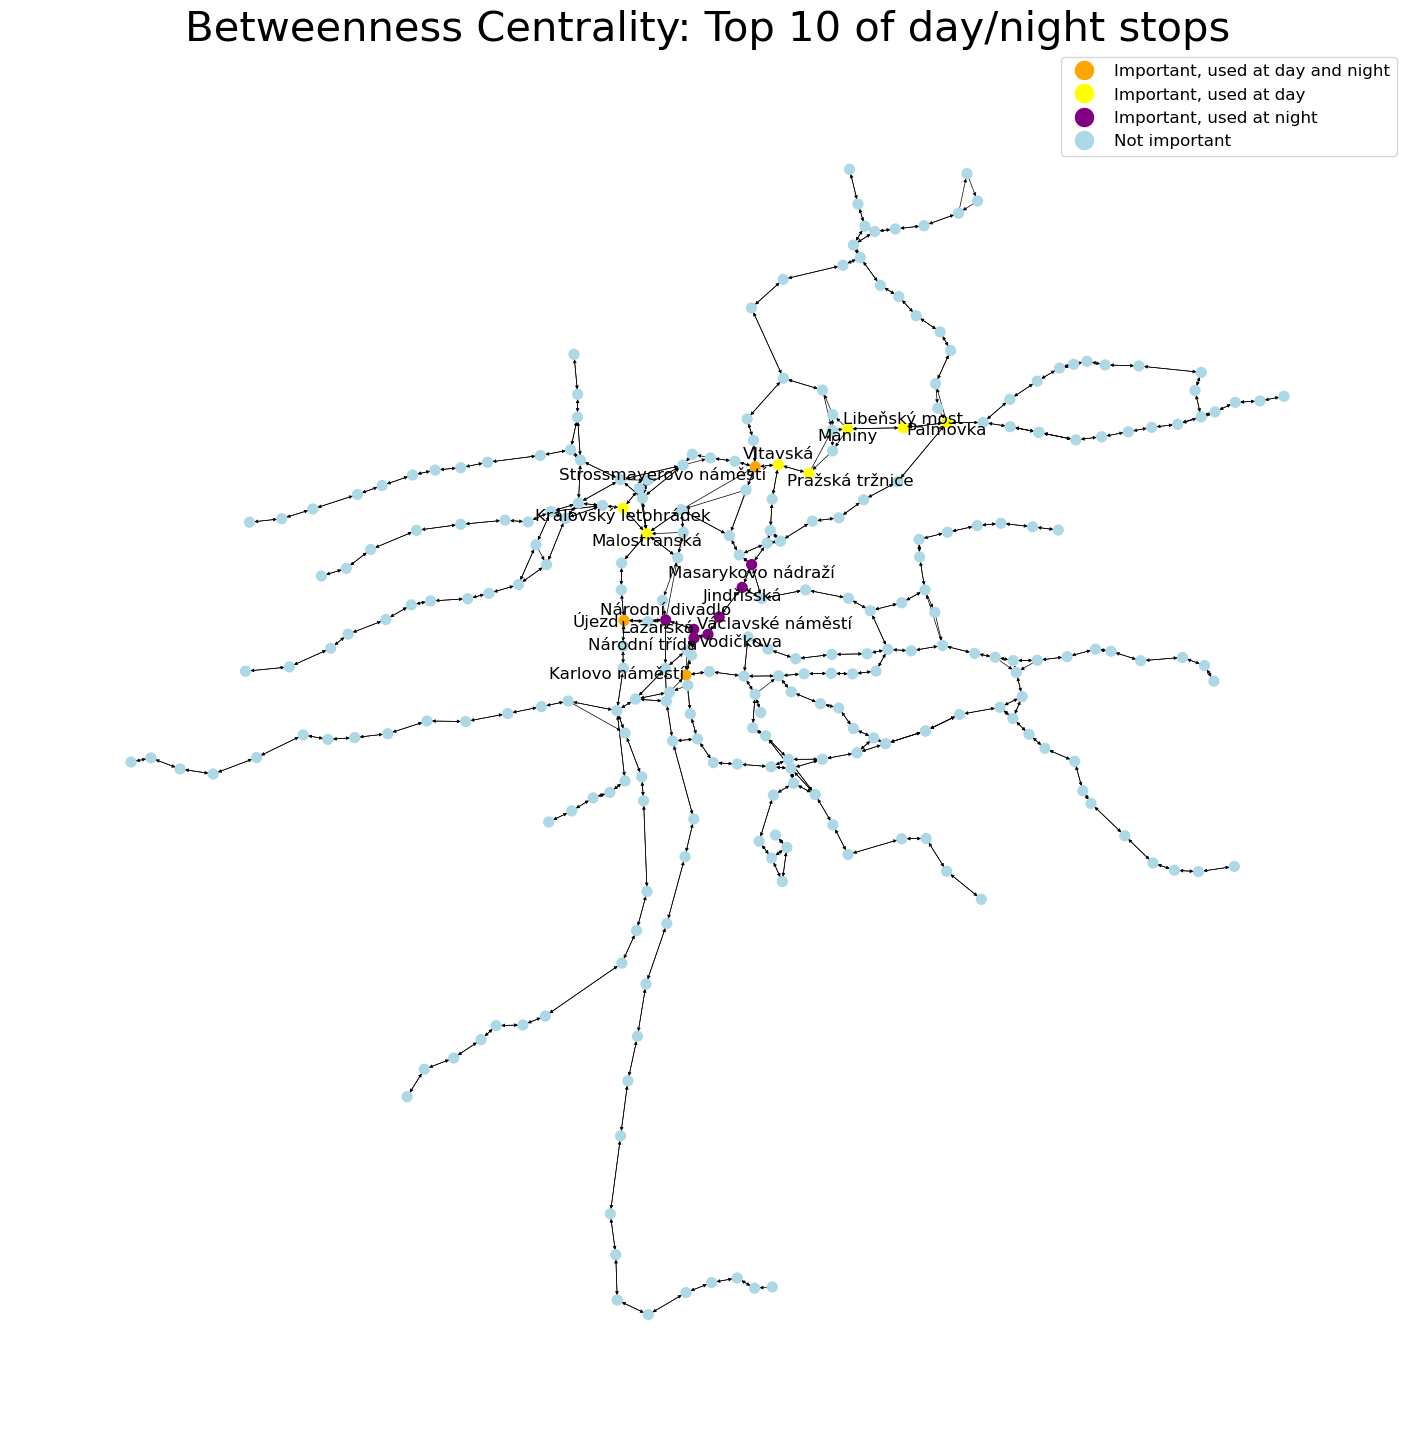

In [290]:
fig, ax = plt.subplots(figsize=(18, 18))

day_nodes = [x[0] for x in day_betweenness_centrality[:-11:-1]]
night_nodes = [x[0] for x in night_betweenness_centrality[:-11:-1]]

colormap = []
for node in G.nodes():
      if node in day_nodes and node in night_nodes:
            colormap.append("orange")
      elif node in day_nodes:
            colormap.append("yellow")
      elif node in night_nodes:
            colormap.append("purple")
      else:
            colormap.append("lightblue")

labels = {}
for x in day_nodes:
      labels[x] = x
for x in night_nodes:
      labels[x] = x

# Small correction for legible graph
pos_labels['Libeňský most'] += [0,0.002]
pos_labels['Vltavská'] += [0,0.002]
pos_labels['Strossmayerovo náměstí'] -= [0.025,0]
pos_labels['Pražská tržnice'] += [0.009,0]

nx.draw_networkx_nodes(G,pos,node_size=50,ax=ax,node_color=colormap)
nx.draw_networkx_edges(G,pos,node_size=50,ax=ax,arrowsize=5,style='solid',width=0.5)
nx.draw_networkx_labels(G,pos_labels,labels=labels,font_size=12,verticalalignment='top')

plt.title("Betweenness Centrality: Top 10 of day/night stops",fontsize=30)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Important, used at day and night',markerfacecolor='orange', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used at day',markerfacecolor='yellow', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used at night',markerfacecolor='purple', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Not important',markerfacecolor='lightblue', markersize=15),        
]
plt.legend(handles=legend_elements, loc='upper right',fontsize='large')
plt.axis('off')
plt.show()

## Je rozdíl ve vytíženosti zastávek metra během pracovního týdne/víkendu?

Míru vytíženosti zastávek lze znázornit pomocí centrality blizkosti. Tato centralita urcuje dulezitost zastavky vzhledem k tomu, jak je daleko od ostatnich zastavek. Náš graf je vážený orientovaný graf a čím větší váhu má hrana, tím častěji se používá.

Zastávky, které jsou těmito hranami propojeny, jsou tedy používány častěji. Výpočtem centrality blízkosti zjistíme nejpoužívanější zastávky pro víkendy/pracovní dny.

Metro podle documentace ma `"route_type"` roven 1:

In [291]:
metro = df[df['route_type'] == 1]

workdays = metro.drop(columns=['saturday','sunday'])
weekends = metro.drop(columns=['monday','tuesday','wednesday','thursday','friday'])

workdays['weight'] = workdays['monday'] + workdays['tuesday'] + workdays['wednesday'] + workdays['thursday'] + workdays['friday']
weekends['weight'] = weekends['saturday'] + weekends['sunday']


tmp = metro.groupby(['stop_from_name','stop_to_name']).sum()
metro_edges = tmp['weight'].reset_index(name="weight")
max_weight = metro_edges.max()['weight']
tmp['distance'] = max_weight / tmp['weight'] 
distances = tmp['distance'].reset_index(name="distance")
metro_edges['distance'] = distances['distance']


tmp = workdays.groupby(['stop_from_name','stop_to_name']).sum()
work_edges = tmp['weight'].reset_index(name="weight")
max_weight = work_edges.max()['weight']
tmp['distance'] = max_weight / tmp['weight'] 
distances = tmp['distance'].reset_index(name="distance")
work_edges['distance'] = distances['distance']
display(work_edges)



tmp2 = weekends.groupby(['stop_from_name','stop_to_name']).sum()
weekend_edges = tmp2['weight'].reset_index(name="weight")
max_weight = weekend_edges.max()['weight']
tmp2['distance'] = max_weight / tmp2['weight'] 
distances = tmp2['distance'].reset_index(name="distance")
weekend_edges['distance'] = distances['distance']
display(weekend_edges)

,stop_from_name,stop_to_name,weight,distance
0,Anděl,Karlovo náměstí,1420,1.169014
1,Anděl,Smíchovské nádraží,1425,1.164912
2,Bořislavka,Dejvická,1285,1.291829
3,Bořislavka,Nádraží Veleslavín,1290,1.286822
4,Budějovická,Kačerov,1660,1.000000
...,...,...,...,...
111,Černý Most,Rajská zahrada,1420,1.169014
112,Českomoravská,Palmovka,1425,1.164912
113,Českomoravská,Vysočanská,1420,1.169014
114,Želivského,Flora,1290,1.286822


,stop_from_name,stop_to_name,weight,distance
0,Anděl,Karlovo náměstí,379,1.005277
1,Anděl,Smíchovské nádraží,381,1.000000
2,Bořislavka,Dejvická,282,1.351064
3,Bořislavka,Nádraží Veleslavín,284,1.341549
4,Budějovická,Kačerov,365,1.043836
...,...,...,...,...
111,Černý Most,Rajská zahrada,316,1.205696
112,Českomoravská,Palmovka,380,1.002632
113,Českomoravská,Vysočanská,316,1.205696
114,Želivského,Flora,345,1.104348


In [292]:
metro_G = nx.from_pandas_edgelist(metro_edges,'stop_from_name','stop_to_name',edge_attr=['weight','distance'],create_using=nx.DiGraph())

work_G = nx.from_pandas_edgelist(work_edges,'stop_from_name','stop_to_name',edge_attr=['weight','distance'],create_using=nx.DiGraph())
weekend_G = nx.from_pandas_edgelist(weekend_edges,'stop_from_name','stop_to_name',edge_attr=['weight','distance'],create_using=nx.DiGraph())

work_bet_cent = nx.closeness_centrality(work_G,distance='distance')
work_betweenness_centrality = []
for x in work_bet_cent.keys():
      work_betweenness_centrality.append([x,work_bet_cent[x]]);
work_betweenness_centrality.sort(key=lambda x: x[1])

weekend_bet_cent = nx.closeness_centrality(weekend_G,distance='distance')
weekend_betweenness_centrality = []
for x in weekend_bet_cent.keys():
      weekend_betweenness_centrality.append([x,weekend_bet_cent[x]]);
weekend_betweenness_centrality.sort(key=lambda x: x[1])

print("{:^51}    {:^51}".format("Workdays","Weekends"))
print("{:^106}".format("Closeness Centrality"))
print("{:^51}    {:^51}".format("====================TOP 10 STOPS====================","====================TOP 10 STOPS===================="))
for work_x,weekend_x in zip(work_betweenness_centrality[:-11:-1],weekend_betweenness_centrality[:-11:-1]):
      print("{:<30}{:<21}     {:<30}{:<21}".format(work_x[0],work_x[1],weekend_x[0],weekend_x[1]))
print("\n\n")
print("{:^51}     {:^51}".format("------------------BOTTOM 10 STOPS------------------","------------------BOTTOM 10 STOPS------------------"))
for work_x,weekend_x in zip(work_betweenness_centrality[:10:],weekend_betweenness_centrality[:10:]):
      print("{:<30}{:<21}     {:<30}{:<21}".format(work_x[0],work_x[1],weekend_x[0],weekend_x[1])) 

                     Workdays                                               Weekends                      
                                           Closeness Centrality                                           
====================TOP 10 STOPS====================    ====================TOP 10 STOPS====================
Muzeum                        0.15181441617873312       Můstek                        0.16154275177859073  
Můstek                        0.15111147782862824       Muzeum                        0.15937314297787458  
Hlavní nádraží                0.14387556019726497       Náměstí Republiky             0.1524271094481234   
Florenc                       0.1431258067283202        Florenc                       0.15092534788135162  
Náměstí Republiky             0.14189475297989723       Hlavní nádraží                0.15019108300781073  
I. P. Pavlova                 0.13786150673930145       Národní třída                 0.14736890383697945  
Národní třída                

In [293]:
work_nodes = [x[0] for x in work_betweenness_centrality[:-11:-1]]
weekend_nodes = [x[0] for x in weekend_betweenness_centrality[:-11:-1]]

colormap = []
for node in metro_G.nodes():
      if node in work_nodes and node in weekend_nodes:
            colormap.append("orange")
      elif node in work_nodes:
            colormap.append("yellow")
      elif node in weekend_nodes:
            colormap.append("purple")
      else:
            colormap.append("lightblue")

labels = {}
for x in work_nodes:
      labels[x] = x
for x in weekend_nodes:
      labels[x] = x

metro_pos = {}
for i,x in enumerate(metro_G.nodes()):
      pos_list = []
      stops_list = stops[stops['stop_name'] == x]
      for index in range(len(stops_list)):
            pos_list.append([stops_list.iloc[index,3],stops_list.iloc[index,2]])
      mean_lon, mean_lat = 0, 0
      for lon,lat in pos_list:
            mean_lon += lon
            mean_lat += lat
      metro_pos[x] = np.array([mean_lon/len(pos_list) ,mean_lat/len(pos_list)])

metro_pos_labels = copy.deepcopy(metro_pos)

Pojdme zvizualizovat 10 nejdůležitějších zastávek v pracovni dny a o vikendy.
* Oranžová barva označuje zastávky, které jsou v top 10 zastávek v pracovni dny a o vikendy
* Žlutá barva - zastávky, které jsou pouze v top 10 v pracovni dny
* Fialová barva zastávky, které jsou pouze v top 10 o vikendy

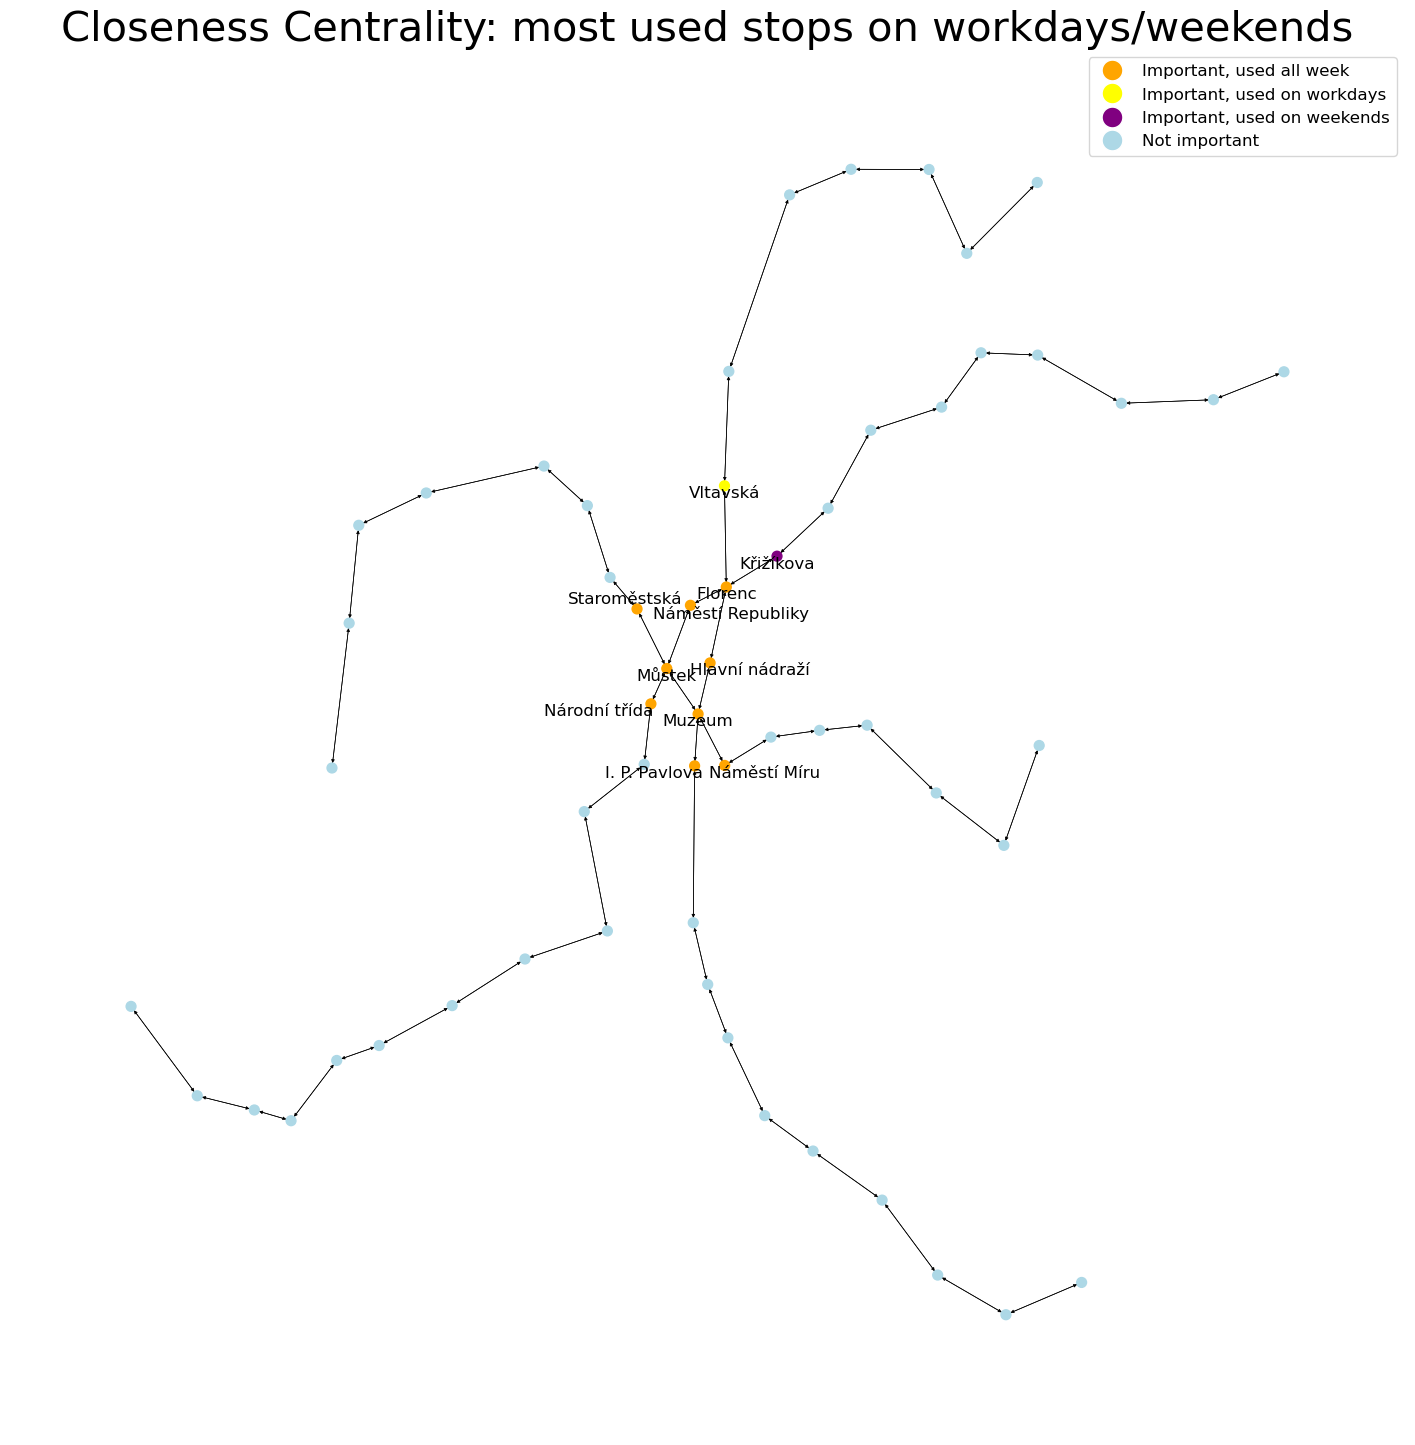

In [294]:
fig, ax = plt.subplots(figsize=(18, 18))
# Small correction for legible graph
metro_pos_labels['Hlavní nádraží'] += [0.010,0]
metro_pos_labels['Staroměstská'] += [-0.003,0.0015]
metro_pos_labels['Náměstí Republiky'] += [0.010,0]
metro_pos_labels['Náměstí Míru'] += [0.010,0]
metro_pos_labels['I. P. Pavlova'] -= [0.010,0]
metro_pos_labels['Národní třída'] -= [0.013,0]

nx.draw_networkx_nodes(metro_G,metro_pos,node_size=50,ax=ax,node_color=colormap)
nx.draw_networkx_edges(metro_G,metro_pos,node_size=50,ax=ax,arrowsize=5,style='solid',width=0.5)
nx.draw_networkx_labels(G,metro_pos_labels,labels=labels,font_size=12,verticalalignment='top')

plt.title("Closeness Centrality: most used stops on workdays/weekends",fontsize=30)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Important, used all week',markerfacecolor='orange', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used on workdays',markerfacecolor='yellow', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Important, used on weekends',markerfacecolor='purple', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Not important',markerfacecolor='lightblue', markersize=15),        
]
plt.legend(handles=legend_elements, loc='upper right',fontsize='large')

plt.axis('off')
plt.show()

Z dat a vizualizace vidíme, že využití zastávek metra ve všední dny a o víkendech je téměř stejné. Jediný rozdíl: v pracovni dny je jednou z nejvytíženějších (tj. nejčastěji využívaných) zastávek Vltavska, ale o víkendu je to Křižíkova.

## Na kterých tramvajových zastávkách je možné nastoupit s invalidním vozíkem?

Tuto otázku nejlépe zodpovíme tak, že sestrojíme graf a označíme v něm zastávky s touto možností.

Dataset `"stops"` neobsahuje informace o tom, zda je konkrétní zastávka tramvajovou zastávkou nebo jiným typem zastávky. Proto může mít zastávka se stejným názvem různé hodnoty parametru "wheelchair_boarding".
* Aby bylo možné přesně ukázat, na kterých zastávkách je možné nastoupit do tramvaje s invalidním vozíkem, je nutné najít zastávky se stejným názvem a aby všechny měly parametr roven 1.

In [295]:
# On which tram stops wheelchair boarding is available?

# Select tram stops
mask = [stops.iloc[i,1] in G.nodes() for i in range(stops['stop_name'].size)]
tmp = stops.loc[mask]

# Group by value of 'stop_name' and 'wheelchair_boarding'  
tmp = tmp.set_index(['stop_name','wheelchair_boarding'])['stop_id'].reset_index().drop(columns=['stop_id'])

# Select max value of 'wheelchair_boarding' for each stop
tmp = tmp.groupby('stop_name')['wheelchair_boarding'].max()

# Select only those, which max is 1
tmp = tmp[tmp == 1].reset_index().drop(columns=['wheelchair_boarding'])
tmp

,stop_name
0,Albertov
1,Anděl
2,Arbesovo náměstí
3,Arena Libeň jih
4,Balabenka
...,...
203,Říčanova
204,Škola Radlice
205,Špejchar
206,Štvanice


Nyní sestrojíme graf. Zastávky, kde je možné nastoupit s invalidním vozíkem, jsou označeny zeleně, jinak - cervene:

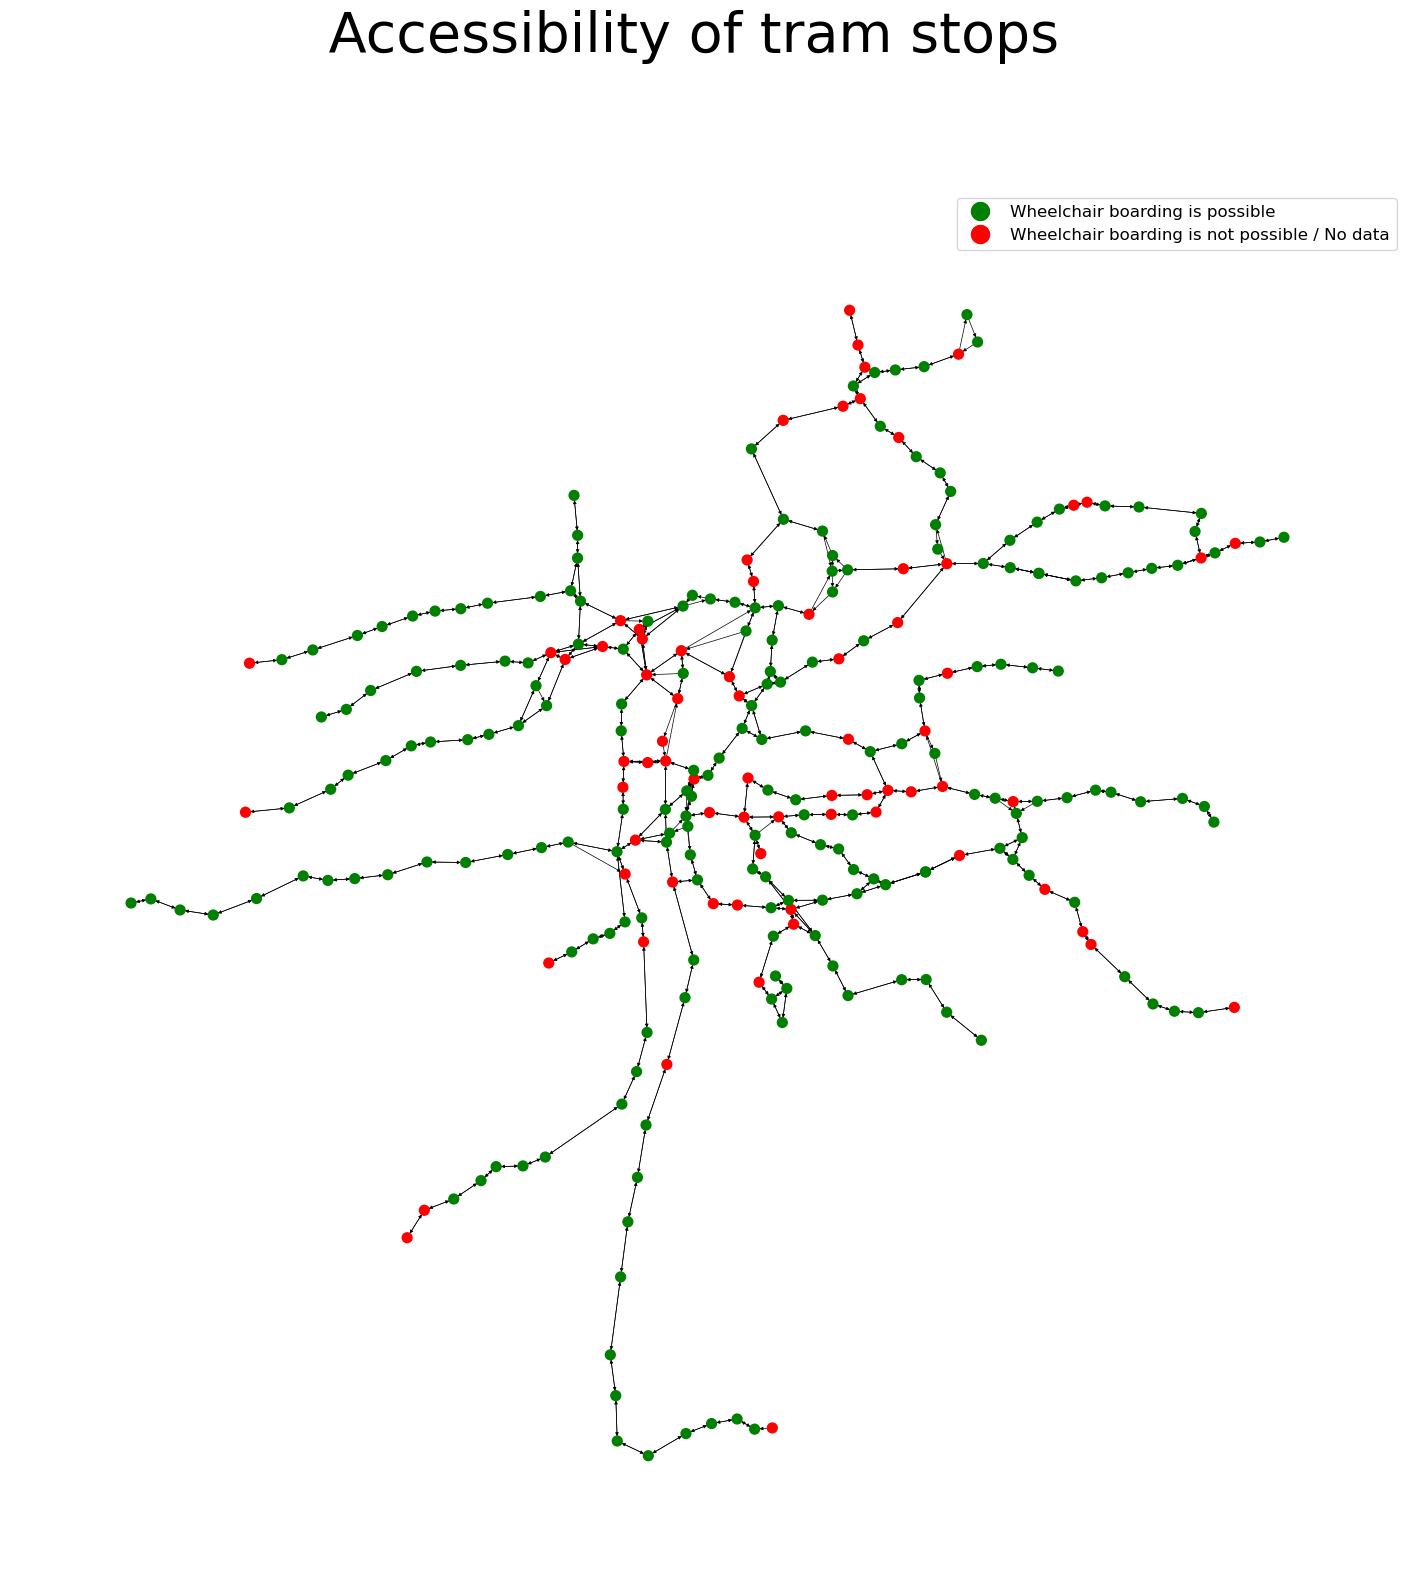

In [296]:
fig, ax = plt.subplots(figsize=(18, 18))
colormap = ["green" if node in tmp.values else "red" for node in G.nodes()]

nx.draw_networkx_nodes(G,pos,node_size=50,ax=ax,node_color=colormap)
nx.draw_networkx_edges(G,pos,node_size=50,ax=ax,arrowsize=5,style='solid',width=0.5)

plt.suptitle(" Accessibility of tram stops",fontsize=40)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Wheelchair boarding is possible',markerfacecolor='green', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Wheelchair boarding is not possible / No data',markerfacecolor='red', markersize=15),        
]
plt.legend(handles=legend_elements, loc='upper right',fontsize='large')
plt.axis("off")
plt.show()

Vidíme, že většina zastávek je označena zeleně, což znamená dobrou dostupnost pro osoby na vozíku. Zastávky, kde to není možné nebo kde nejsou dostatečné informace, jsou označeny červeně.  